In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:

mu = 0
sigma = 1
a = 10
T = 1
epsilon = 0.001
num_samples = 500

t = torch.arange(0, T+epsilon, epsilon)

y_mean = a * t
variance = sigma**2 * t * (1 - t/T)
std_dev = torch.sqrt(variance)

upper_bound = y_mean + 3 * std_dev
lower_bound = y_mean - 3 * std_dev

y_bridge = torch.zeros((t.shape[0], num_samples))
drift = torch.zeros((t.shape[0], num_samples))

for i in range(len(t) - 1):
    dt = t[i+1] - t[i]      # dt = epsilon
    dydt = (a * T - y_bridge[i]) / (T - t[i])
    drift[i, :] = dydt
    diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples)
    y_bridge[i+1] = y_bridge[i] + dydt * dt
    y_bridge[i+1, :] += diffusion

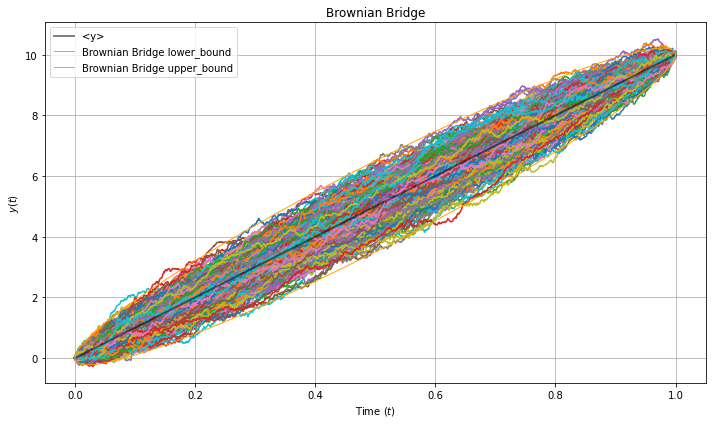

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(t, y_bridge)
plt.plot(t, y_mean, label=r'<y>', linewidth=2, color='black', alpha=0.5)
plt.plot(t, lower_bound, color='orange', linewidth=1, label='Brownian Bridge lower_bound')
plt.plot(t, upper_bound, color='orange', linewidth=1, label='Brownian Bridge upper_bound')


plt.title('Brownian Bridge Smapling')
plt.xlabel('Time ($t$)')
plt.ylabel('$y(t)$')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [25]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=2, hidden_dim=64):
        super(MLP, self).__init__()
        
        self.fcin = nn.Linear(input_dim, hidden_dim)
        self.fcs = nn.ModuleList()
        for i in range(hidden_layers):
            self.fcs.append(nn.Linear(hidden_dim, hidden_dim))
        self.fcout = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ret = self.fcin(x)
        ret = self.relu(ret)
        for fc in self.fcs:
            ret = fc(ret)
            ret = self.relu(ret)
        ret = self.fcout(ret)
        return ret

class BBdataset(Dataset):
    def __init__(self, data):
        self.data = data  
        
    def __len__(self):
        return len(self.data)  
    
    def __getitem__(self, index):
        return self.data[index, :].reshape(1, -1)

In [27]:
def train(model, train_dl, optimizer, loss_fn):
    losses = 0
    
    for training_data in train_dl:
        x, score = training_data[:, :, 0:2], training_data[:, :, -1:]
        x = x.to(device)
        score = score.to(device)

        pred = model(x)
        loss = loss_fn(pred, score)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

times = t[:len(t)-1].repeat(num_samples).reshape(-1, 1)
positions = torch.cat(torch.split(y_bridge[:-1, :], 1, dim=1), dim=0)
scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)

raw_data = torch.concat([times, positions, scores], dim=1)

train_ds = BBdataset(raw_data)
train_dl = DataLoader(train_ds, batch_size=1000, shuffle=True)

model = MLP(input_dim=2, output_dim=1, hidden_layers=2, hidden_dim=128).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
loss_fn = nn.MSELoss()
loss_list = []
epochs = 50
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

==========model==========
batch_szie:1000, channel:1, length:3
MLP(
  (fcin): Linear(in_features=2, out_features=128, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [28]:
epoch_iterator = tqdm(range(epochs), desc="Training (X / X epoch) (loss=X.X)", dynamic_ncols=True)
model.train()
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, loss_fn)
    loss_list.append(now_loss)
    epoch_iterator.set_description("Training (%d epoch) (loss=%2.5f)" % (e+1, now_loss))
epoch_iterator.close()

Training (X / X epoch) (loss=X.X):   0%|          | 0/50 [00:00<?, ?it/s]

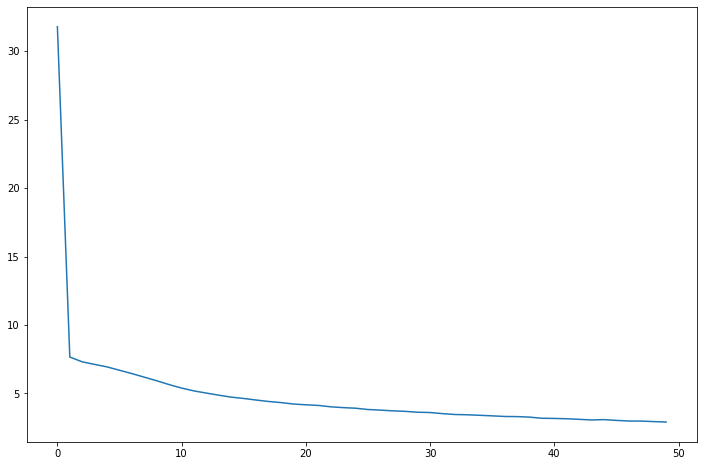

In [29]:
# draw the loss_list for the loss graph
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(epochs), loss_list)
fig.show()

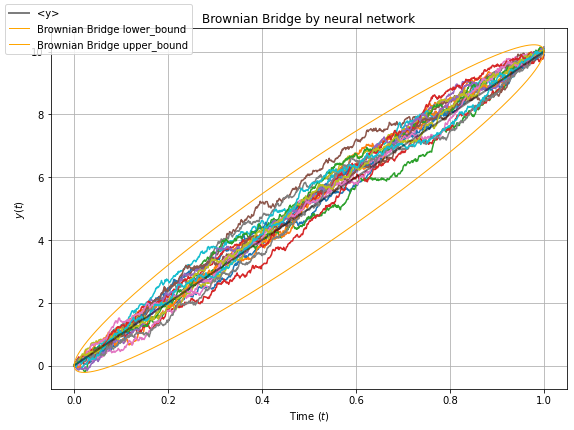

In [40]:
# Test model

test_num_samples = 20
model = model.cpu()
model.eval()
t = torch.arange(0, T+epsilon, epsilon)
preds = torch.zeros((t.shape[0], test_num_samples))

pred_bridge = torch.zeros((t.shape[0], test_num_samples))

for i in range(len(t) - 1):
    dt = t[i+1] - t[i]      # dt = epsilon
    with torch.no_grad():
        x = torch.concat([t[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1), pred_bridge[i].reshape(-1, 1, 1)], axis=-1)
        # print(x.shape)
        dydt = model(x)
        # print(dydt.shape)
    dydt = dydt[:, 0, 0]
    preds[i, :] = dydt
    diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples)
    pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion
    # pred_bridge[i+1, :] += 
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, pred_bridge)
ax.plot(t, y_mean, label=r'<y>', linewidth=2, color='black', alpha=0.5)
ax.plot(t, lower_bound, color='orange', linewidth=1, label='Brownian Bridge lower_bound')
ax.plot(t, upper_bound, color='orange', linewidth=1, label='Brownian Bridge upper_bound')


ax.set_title('Brownian Bridge by neural network')
ax.set_xlabel('Time ($t$)')
ax.set_ylabel('$y(t)$')
ax.grid(True)
fig.legend(loc='upper left')
fig.tight_layout()

plt.savefig('outs/brownian_bridge_pred.jpg', dpi=300)
# writer.add_image('images', fig, 0)

plt.show()